In [139]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import sys
import json
from optparse import OptionParser, make_option
sys.path.insert(0, '/users/nchernya/HHbbgg_ETH/bregression/python/')
import plotting_utils as plotting
import pprint
import matplotlib.offsetbox as offsetbox 

In [140]:
input_metrics='loss,mae0,mse0'.split(',')
njobs=50
input_trainings=[('2018-02-03_17_57_53_job%i'%i+'/') for i in range(0,njobs)]
nxval=5
inp_dir=os.environ['SCRATCH']+'/bregression/NN_output/'
inp_file='metrics'
colors=['r','b','g','k','c','y']

In [233]:
dictVar={}
all_means=[]
all_stds=[]
param_dicts=[]
full_data_frames=[]
met=input_metrics[2]
for idx_nn,nn in enumerate(input_trainings): 
    j = json.load(open('%s/%s/config.json'%(inp_dir,nn)))
    param_dicts.append(dict(lr=j['model_params']['optimizer_params']['lr'],dropout=j['model_params']['dropout'],architecture=j['model_params']['layers'],loss=j['model_params']['loss'],trainable_params=j['Trainable_params'],jobnum=idx_nn))
    xval_data_frames=[]
    for xval in range(0,nxval):
       # load data from metrics.csv file
        tmp_data = pd.read_csv('%s/%s/%s_kfold%i.csv'%(inp_dir,nn,inp_file,xval))
        xval_data_frames.append(tmp_data)
    if idx_nn==0 :  
        for i,column in enumerate(xval_data_frames[0].columns.values.tolist()):
            dictVar[column] = i
    mean = np.mean( np.array( [ xval_data_frames[i].as_matrix() for i in range(0,xval)] ), axis=0 )
    dataframe = pd.DataFrame()
    dataframe['val_mean_%s_job%i'%(met,idx_nn)] = mean[:,dictVar['val_%s'%met]]
    dataframe['mean_%s_job%i'%(met,idx_nn)] = mean[:,dictVar['%s'%met]]
    rolling_mean = dataframe['val_mean_%s_job%i'%(met,idx_nn)].rolling(window=5).mean()
    rolling_std = dataframe['val_mean_%s_job%i'%(met,idx_nn)].rolling(window=5).std()
    dataframe['val_rolling_mean_%s_job%i'%(met,idx_nn)] = rolling_mean
    dataframe['val_rolling_std_%s_job%i'%(met,idx_nn)] = rolling_std
    dataframe['epoch']=mean[:,dictVar['epoch']]
    dataframe['jobid']='job%i'%idx_nn
    dataframe['jobid']='job%i'%idx_nn
    dataframe['architecture']=str(param_dicts[idx_nn]['architecture'])
    dataframe['loss']=str(param_dicts[idx_nn]['loss'])
    dataframe['learning_rate']=str(param_dicts[idx_nn]['lr'])
    dataframe['dropout']=str(param_dicts[idx_nn]['dropout'])
    dataframe['trainable_params']=str(param_dicts[idx_nn]['trainable_params'])
    full_data_frames.append(dataframe)

In [234]:
from IPython.display import display

In [ ]:
#display(full_data_frames[0])

In [235]:
#Plot 2D map of validation loss scores vs job# and epoch
weights=np.array(np.vstack(full_data_frames[i]['val_mean_%s_job%i'%(met,i)] for i in range(njobs)),dtype='float64')
bins_x_epochs=full_data_frames[0]['epoch']
bins_y_jobs=[i for i in range(0,njobs)]
X2d_bins,Y2d_bins=np.meshgrid(bins_x_epochs,bins_y_jobs)

In [236]:
#color maps : RdBu_r, 
import datetime
now = datetime.datetime.now()
now = str(now).split(' ')[0]
plotoutput_dir = '/users/nchernya//HHbbgg_ETH/bregression/plots/NN_optimization/%s/'%(now)
if not os.path.exists(plotoutput_dir):
    os.mkdir(plotoutput_dir)
plotoutput_dir+='/%s/'%(met)
if not os.path.exists(plotoutput_dir):
    os.mkdir(plotoutput_dir)

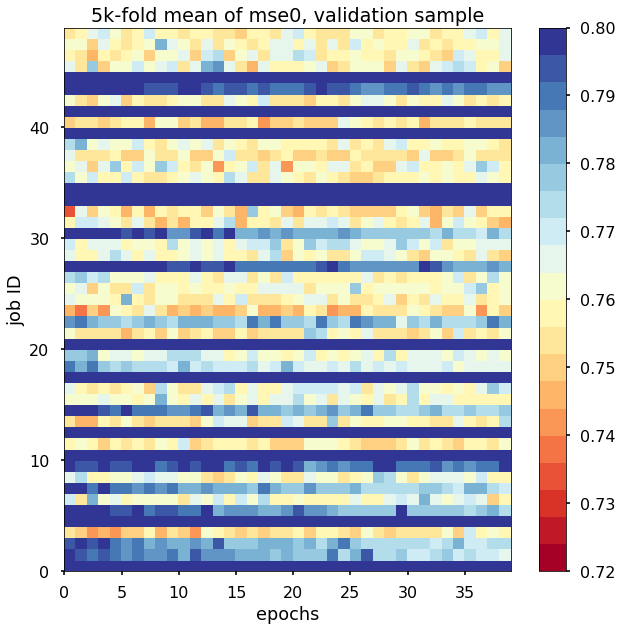

In [240]:
im = plt.pcolormesh(X2d_bins,Y2d_bins,weights, cmap=plt.cm.get_cmap('RdYlBu',20)) 
plt.colorbar()
#plt.clim(0.40,0.45)  #for loss
#plt.clim(0.47,0.50) # for mae
plt.clim(0.72,0.80) # for mse
plt.title('5k-fold mean of %s, validation sample'%met)
plt.xlabel('epochs')
plt.ylabel('job ID')
axes=plt.gca()
#axes.grid(True,axis='y',markevery=0.1)
ymin, ymax = axes.get_ylim()
plt.show()
name = plotoutput_dir+'plot_2Dcolormesh_%s_valid_mean'%met
plt.savefig(name+'.pdf')
plt.savefig(name+'.png')

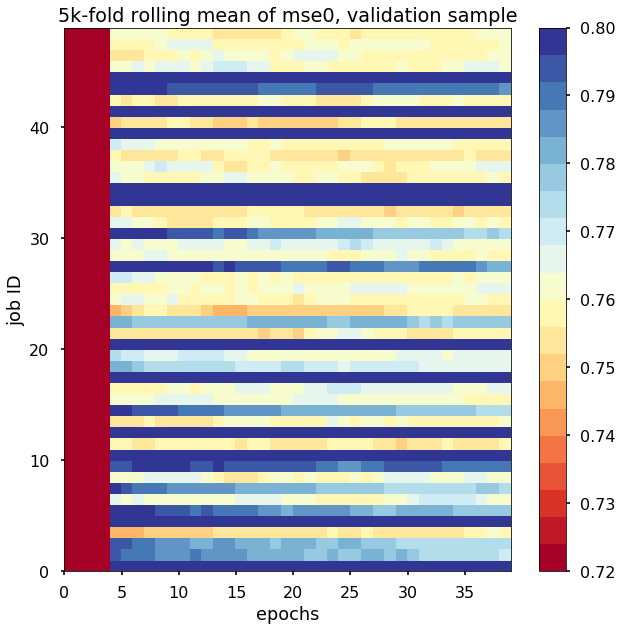

In [241]:
weights_rolling=np.array(np.vstack(full_data_frames[i]['val_rolling_mean_%s_job%i'%(met,i)].fillna(0.5) for i in range(njobs)),dtype='float64')
im = plt.pcolormesh(X2d_bins,Y2d_bins,weights_rolling, cmap=plt.cm.get_cmap('RdYlBu',20)) 
plt.colorbar()
plt.title('5k-fold rolling mean of %s, validation sample'%met)
#plt.clim(0.40,0.45)  #for loss
#plt.clim(0.47,0.50) # for mae
plt.clim(0.72,0.80) # for mse
plt.xlabel('epochs')
plt.ylabel('job ID')
axes=plt.gca()
#axes.grid(True,axis='y',markevery=0.1)
ymin, ymax = axes.get_ylim()
plt.show()
name = plotoutput_dir+'plot_2Dcolormesh_%s_valid_rolling_mean'%met
plt.savefig(name+'.pdf')
plt.savefig(name+'.png')

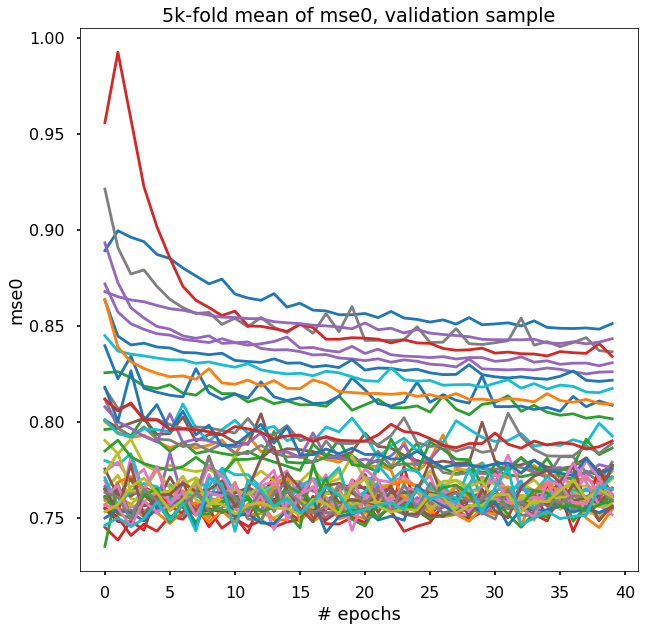

In [242]:
for i in range(njobs):
    plt.plot(full_data_frames[i]['epoch'],full_data_frames[i]['val_mean_%s_job%i'%(met,i)])
    plt.title('5k-fold mean of %s, validation sample'%met)
    plt.xlabel('# epochs')
    plt.ylabel('%s'%met)
plt.show()
name = plotoutput_dir+'plot_loss_epochs_%s_valid_mean'%met
plt.savefig(name+'.pdf')
plt.savefig(name+'.png')

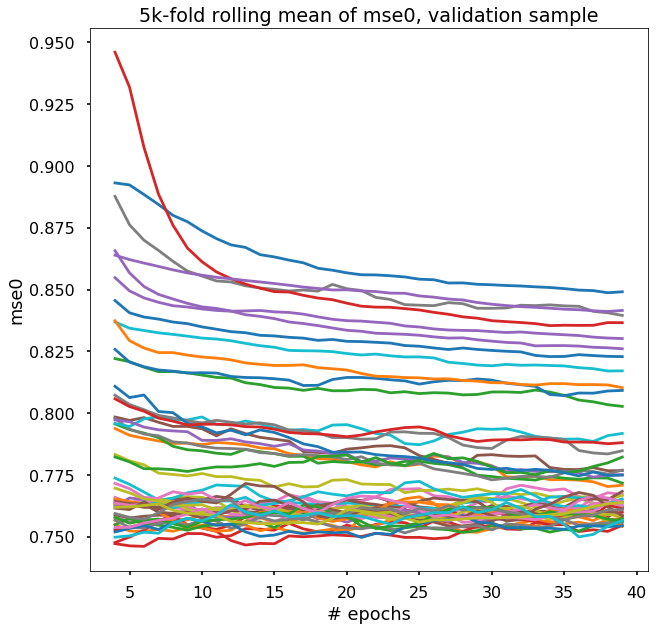

In [243]:
for i in range(njobs):
    plt.plot(full_data_frames[i]['epoch'],full_data_frames[i]['val_rolling_mean_%s_job%i'%(met,i)])
    plt.title('5k-fold rolling mean of %s, validation sample'%met)
    plt.xlabel('# epochs')
    plt.ylabel('%s'%met)
plt.show()
name = plotoutput_dir+'plot_loss_epochs_%s_valid_rolling_mean'%met
plt.savefig(name+'.pdf')
plt.savefig(name+'.png')

In [244]:
parameters = list(set([full_data_frames[i].get_value(num_epochs-1,'trainable_params') for i in range(njobs)]))
print(parameters)

['728265', '4930761', '184009', '2829513']


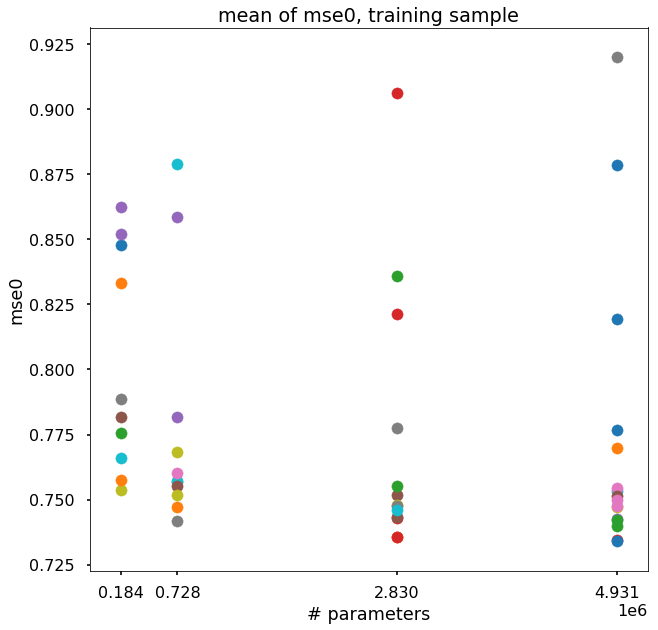

In [245]:
num_epochs=len(full_data_frames[0].index)
for i in range(njobs):
    plt.scatter(full_data_frames[i].get_value(num_epochs-1,'trainable_params'),full_data_frames[i].get_value(num_epochs-1,'mean_%s_job%i'%(met,i)))
    plt.title('mean of %s, training sample'%met)
    plt.xlabel('# parameters')
    plt.ylabel('%s'%met)
ax = plt.gca()
ax.set_xticks([int(parameters[i]) for i in range(len(parameters))]) # choose which x locations to have ticks
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.show()
name = plotoutput_dir+'plot_loss_complexity_%s_training'%met
plt.savefig(name+'.pdf')
plt.savefig(name+'.png')

In [246]:
jobs_parameters = [int(full_data_frames[i].get_value(num_epochs-1,'trainable_params')) for i in range(njobs)]
trained_mean = [full_data_frames[i].get_value(num_epochs-1,'mean_%s_job%i'%(met,i)) for i in range(njobs)]
val_rolling_mean = [full_data_frames[i].get_value(num_epochs-1,'val_rolling_mean_%s_job%i'%(met,i)) for i in range(njobs)]
val_mean = [full_data_frames[i].get_value(num_epochs-1,'val_mean_%s_job%i'%(met,i)) for i in range(njobs)]


best_trainings = pd.DataFrame({'trainable_params':jobs_parameters,'trained_mean':trained_mean,'val_rolling_mean':val_rolling_mean,'val_mean':val_mean,'jobid':[i for i in range(njobs)]})

validation = 0.755801, training = 0.741609
validation = 0.754415, training = 0.734168
validation = 0.756565, training = 0.753708
validation = 0.754634, training = 0.735618
best jobs ids :  [37, 40, 28, 23]


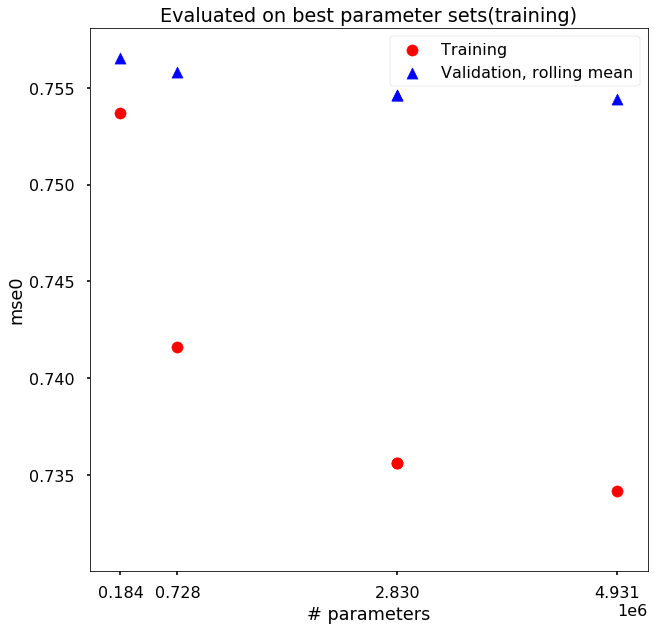

In [249]:
best_jobids=[]
for i in range(len(parameters)):
    df_param = best_trainings['trainable_params']==int(parameters[i])
    min_trained = best_trainings[df_param]['trained_mean'].min()
    df_trained = best_trainings['trained_mean']==min_trained
    validation = best_trainings[df_param & df_trained]['val_rolling_mean'].min()
    best_jobids.append(best_trainings[df_param & df_trained]['jobid'].min())
    plt.scatter(int(parameters[i]),min_trained,color='r')
    plt.scatter(int(parameters[i]),validation,color='b',marker='^')
    print('validation = %f, training = %f'%(validation,min_trained))
print('best jobs ids : ',best_jobids)
plt.scatter(int(parameters[i]),min_trained,color='r',label='Training')
plt.scatter(int(parameters[i]),validation,color='b',marker='^',label='Validation, rolling mean')
plt.xlabel('# parameters')
plt.ylabel('%s'%met)
plt.title('Evaluated on best parameter sets(training)')
ax = plt.gca()
ax.set_xticks([int(parameters[i]) for i in range(len(parameters))]) # choose which x locations to have ticks
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.legend()
plt.show()

validation = 0.755801, training = 0.741609
validation = 0.754415, training = 0.734168
validation = 0.754216, training = 0.757674
validation = 0.754634, training = 0.735618
best jobs ids :  [37, 40, 31, 23]


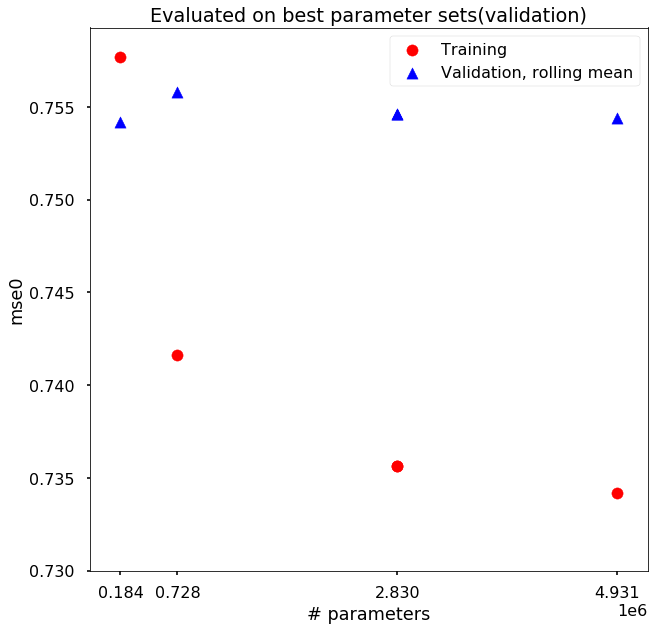

In [250]:
best_jobids=[]
for i in range(len(parameters)):
    df_param = best_trainings['trainable_params']==int(parameters[i])
    min_trained = best_trainings[df_param]['val_rolling_mean'].min()
    df_trained = best_trainings['val_rolling_mean']==min_trained
    validation = best_trainings[df_param & df_trained]['trained_mean'].min()
    best_jobids.append(best_trainings[df_param & df_trained]['jobid'].min())
    plt.scatter(int(parameters[i]),validation,color='r')
    plt.scatter(int(parameters[i]),min_trained,color='b',marker='^')
    print('validation = %f, training = %f'%(min_trained,validation))
print('best jobs ids : ',best_jobids)
plt.scatter(int(parameters[i]),validation,color='r',label='Training')
plt.scatter(int(parameters[i]),min_trained,color='b',marker='^',label='Validation, rolling mean')
plt.xlabel('# parameters')
plt.ylabel('%s'%met)
plt.title('Evaluated on best parameter sets(validation)')
ax = plt.gca()
ax.set_xticks([int(parameters[i]) for i in range(len(parameters))]) # choose which x locations to have ticks
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.legend()
plt.show()
name = plotoutput_dir+'plot_loss_complexity_%s_train_valid'%met
plt.savefig(name+'.pdf')
plt.savefig(name+'.png')

In [251]:
print("Best jobs : ")
for i in range(len(best_jobids)):
    print('job #%i'%i)
    print('# Parameters : ',full_data_frames[best_jobids[i]].get_value(num_epochs-1,'trainable_params'))
    print('architecture : ',full_data_frames[best_jobids[i]].get_value(num_epochs-1,'architecture'))
    print('learning rate : ',full_data_frames[best_jobids[i]].get_value(num_epochs-1,'learning_rate'))
    print('dropout: ',full_data_frames[best_jobids[i]].get_value(num_epochs-1,'dropout'))

Best jobs : 
job #0
# Parameters :  728265
architecture :  [1024, 512, 256, 128]
learning rate :  0.0001
dropout:  0.1
job #1
# Parameters :  4930761
architecture :  [1024, 1024, 1024, 1024, 1024, 512, 256, 128]
learning rate :  0.0001
dropout:  0.1
job #2
# Parameters :  184009
architecture :  [512, 256, 128]
learning rate :  0.01
dropout:  0.2
job #3
# Parameters :  2829513
architecture :  [1024, 1024, 1024, 512, 256, 128]
learning rate :  0.001
dropout:  0.1


In [252]:
attributes_selected=['trainable_params','architecture','learning_rate','dropout']
data=[]
for i,job in enumerate(best_jobids):
    item = {"jobid": str(job)}
    for j,attribute in enumerate(attributes_selected):
        item[attribute] = full_data_frames[best_jobids[i]].get_value(num_epochs-1,attribute)
    data.append(item)
jsonData=json.dumps(data,indent=4)
with open(plotoutput_dir+'/best_jobs_%s.json'%met,'w+') as fo:
    fo.write(jsonData)
    fo.close()